<a href="https://colab.research.google.com/github/yashsharma29103/Solar-power-plant-project-final-year/blob/main/Dirt_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Understanding problem

Date Collection

In [ ]:
from google.colab import files
files.upload()

# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Download kaggle api
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d malkamahira/solar-panels-dirt-detection

!unzip /content/solar-panels-dirt-detection.zip -d /content/solar-panels-dirt-detection

 98% 469M/478M [00:05<00:00, 97.2MB/s]
100% 478M/478M [00:05<00:00, 96.8MB/s]
Archive:  /content/solar-panels-dirt-detection.zip
  inflating: /content/solar-panels-dirt-detection/Detect_solar_dust/Clean/Imgclean_1000_0 (2).jpg  
  inflating: /content/solar-panels-dirt-detection/Detect_solar_dust/Clean/Imgclean_1002_0.jpg  
  inflating: /content/solar-panels-dirt-detection/Detect_solar_dust/Clean/Imgclean_1003_0.jpg  
  inflating: /content/solar-panels-dirt-detection/Detect_solar_dust/Clean/Imgclean_1004_0.jpg  
  inflating: /content/solar-panels-dirt-detection/Detect_solar_dust/Clean/Imgclean_1005_0 (2).jpg  
  inflating: /content/solar-panels-dirt-detection/Detect_solar_dust/Clean/Imgclean_1006_0 (2).jpg  
  inflating: /content/solar-panels-dirt-detection/Detect_solar_dust/Clean/Imgclean_1007_0 (2).jpg  
  inflating: /content/solar-panels-dirt-detection/Detect_solar_dust/Clean/Imgclean_1008_0 (2).jpg  
  inflating: /content/solar-panels-dirt-detection/Detect_solar_dust/Clean/Imgclean_

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
from itertools import chain
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

In [ ]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

In [ ]:
# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )

print('Data Augmentation 1 was created')

Data Augmentation 1 was created


In [ ]:
data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )
print('Data Augmentation 2 was created')

Data Augmentation 2 was created


In [ ]:
data_generator_3 = ImageDataGenerator(rescale=1./255)

print('Data Augmentation 3 was created')

Data Augmentation 3 was created


In [ ]:
# Read Training data
train_generator1 = data_generator_1.flow_from_directory(
    directory = "/content/solar-panels-dirt-detection/Detect_solar_dust/",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 1234)

Found 1187 images belonging to 2 classes.


In [ ]:
# Read Testing data
test_generator = data_generator_2.flow_from_directory(
    directory = "/content/solar-panels-dirt-detection/Detect_solar_dust/",
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 1234)

Found 1187 images belonging to 2 classes.


In [ ]:
dict_class = train_generator1.class_indices
print('Dictionary: ',dict_class)

class_names = list(dict_class.keys())
print('Class labels: ',class_names)

Dictionary:  {'Clean': 0, 'Dusty': 1}
Class labels:  ['Clean', 'Dusty']


In [ ]:
frequency = np.unique(train_generator1.classes, return_counts=True)
print(frequency)

(array([0, 1], dtype=int32), array([652, 535]))


([<matplotlib.patches.Wedge at 0x7a17342a1090>,
 [Text(-0.16963335557902312, 1.086841536138089, 'Clean'),
  Text(0.16963335557902298, -1.086841536138089, 'Dusty')],
 [Text(-0.09252728486128532, 0.5928226560753211, '55%'),
  Text(0.09252728486128525, -0.5928226560753211, '45%')])

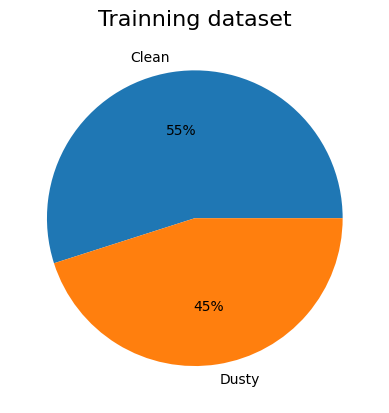

In [ ]:
plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%')

In [ ]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in train_generator1.classes if label == 1]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of normal images:", len([label for label in test_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in test_generator.classes if label == 1]))
print()

Dataset Characteristics of Train Data Set:
Number of images: 1187
Number of normal images: 652
Number of pneumonia images: 535

Dataset Characteristics of Test Data Set:
Number of images: 1187
Number of normal images: 652
Number of pneumonia images: 535



In [ ]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 0.9102760736196319, 1: 1.1093457943925233}

Train image data from Data Augmentation 1


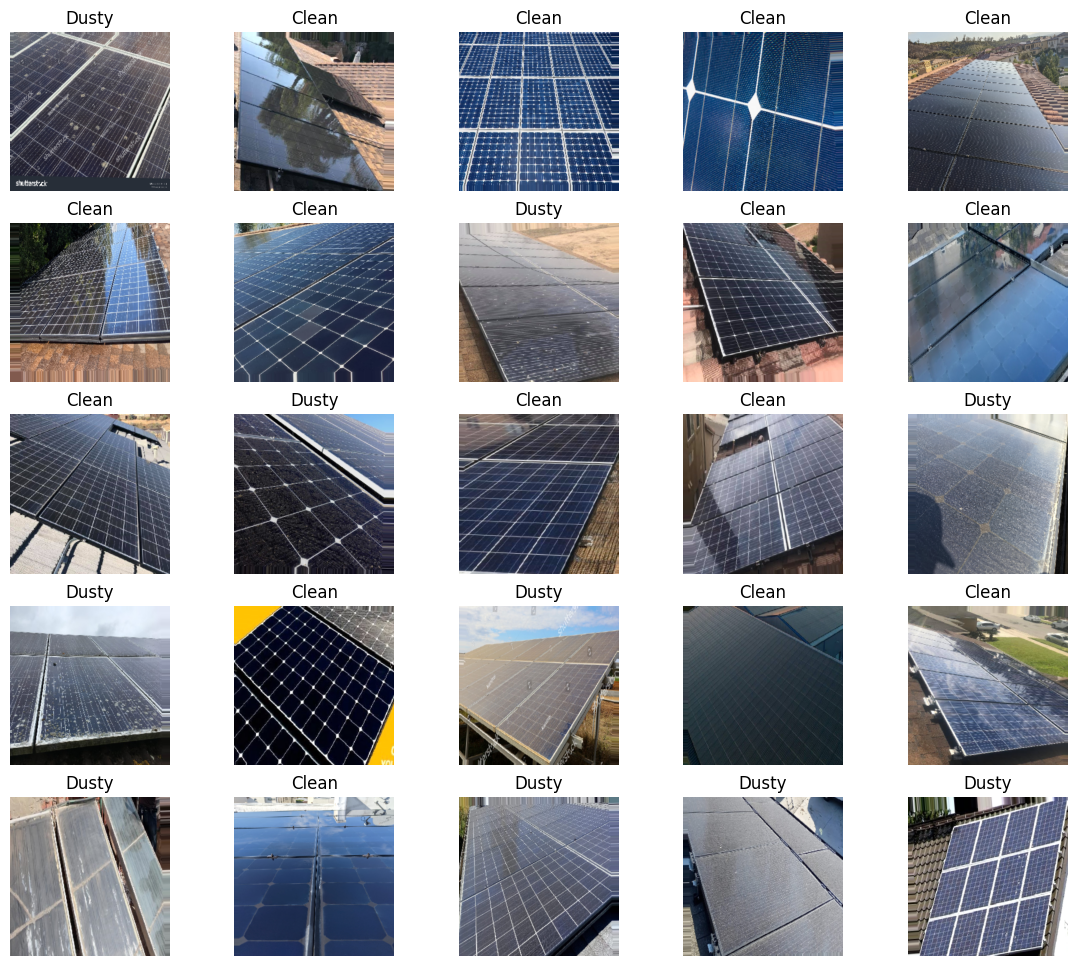

In [ ]:
# Image Samples
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[14, 12])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])
plt.show()

In [ ]:
EPOCHS = 50
num_gpus = 2
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)
train_data = train_generator1

In [ ]:
# Load the pre-trained InceptionV3 model without the top classification layer
base_model_Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_Inception.layers:
    layer.trainable = False

# Create a new model and add the InceptionV3 base model
model_Inception = Sequential()
model_Inception.add(base_model_Inception)

# Add a global average pooling layer and output layer for classification
model_Inception.add(GlobalAveragePooling2D())
model_Inception.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_Inception.add(Dropout(0.4))
model_Inception.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_Inception.add(Dropout(0.2))
model_Inception.add(Dense(2, activation='softmax'))

# Model summary
print("Model Summary (InceptionV3):")
model_Inception.summary()
print()

# Compile the model
model_Inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history_Inception = model_Inception.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

# Validate the model
val_loss_Inception, val_accuracy_Inception = model_Inception.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_Inception:.4f}')
print(f'Validation Accuracy: {val_accuracy_Inception:.4f}')

87910968/87910968 [==============================] - 1s 0us/step
Model Summary (InceptionV3):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)        

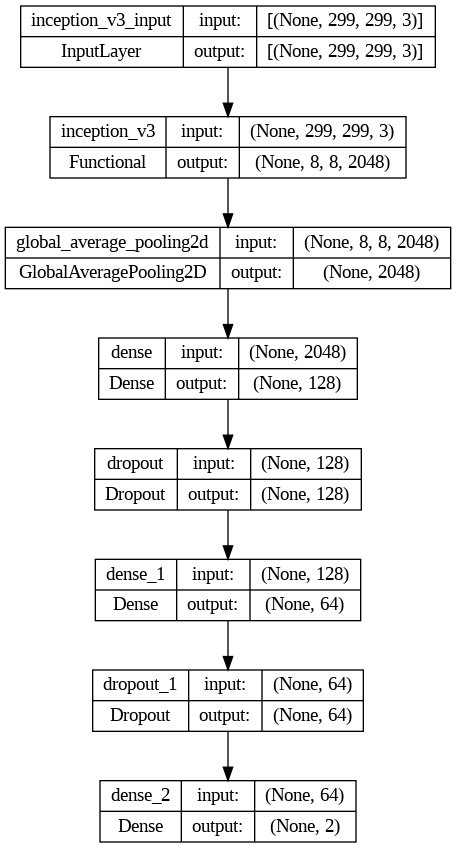

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_Inception, show_shapes=True, show_layer_names=True)

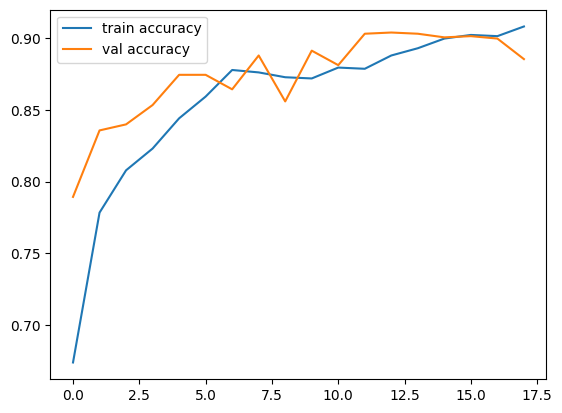

In [ ]:
plt.plot(history_Inception.history['accuracy'],label='train accuracy')
plt.plot(history_Inception.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.show()

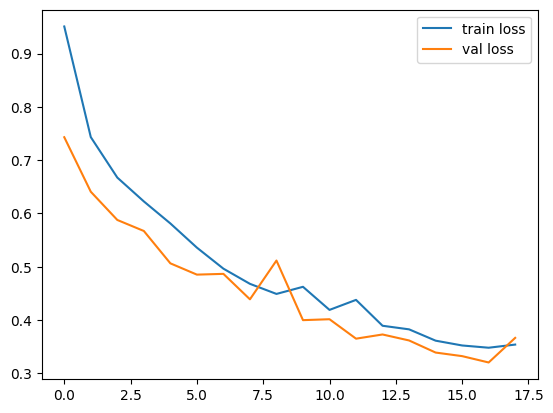

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history_Inception.history['loss'],label='train loss')
plt.plot(history_Inception.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

2/2 [==============================] - 6s 2s/step


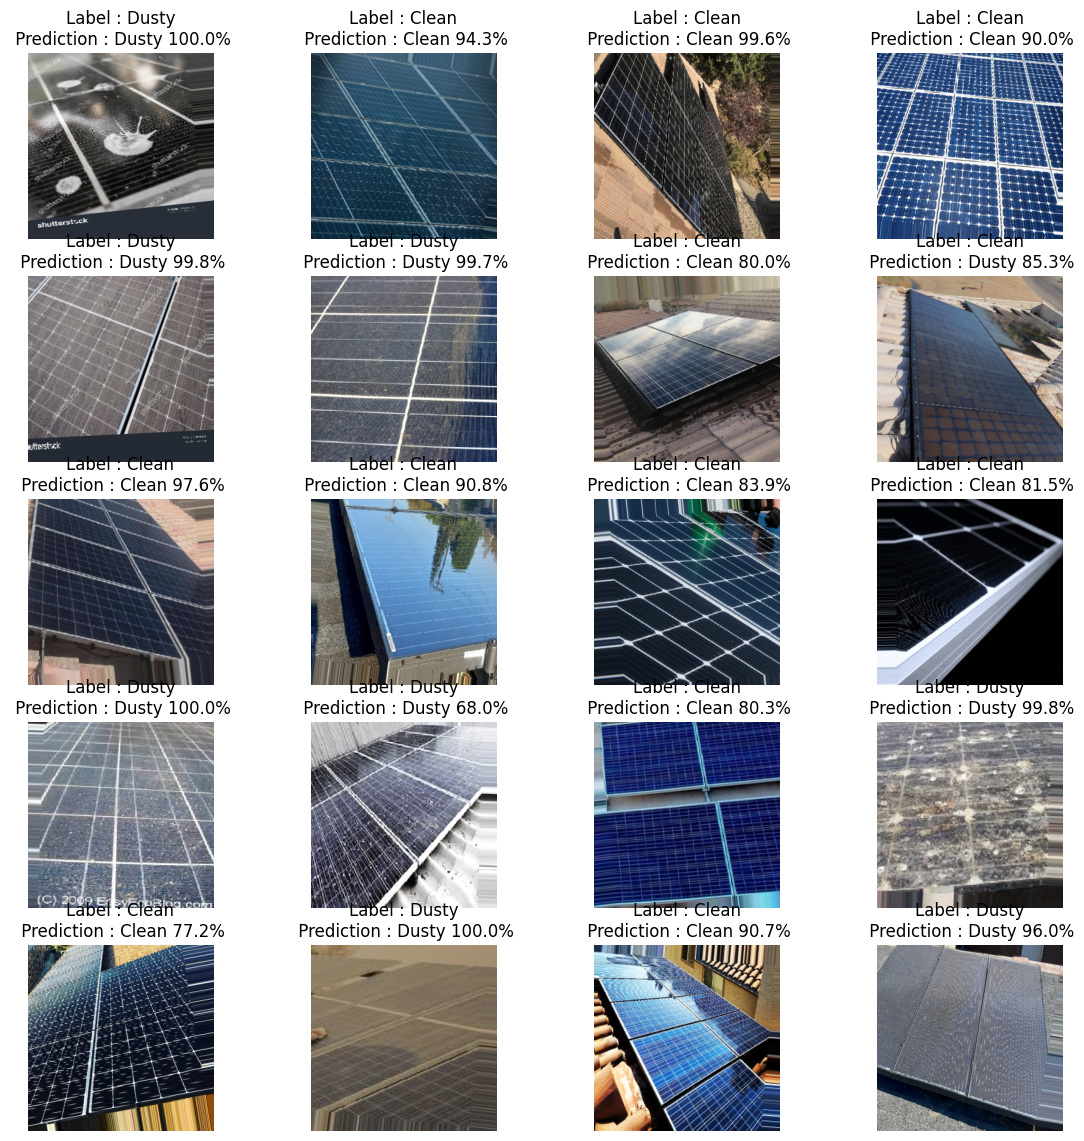

In [ ]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_Inception.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [ ]:
model_Inception.save("model.h5")
print("Saved successfully :)) ")

Saved successfully :)) 


In [ ]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model

# load model
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/model.h5 /content/
model_Inception = load_model('model.h5')
# summarize model.
model_Inception.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                           

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp model.h5 /content/drive/MyDrive

In [ ]:
from keras.applications.vgg16 import VGG16

# Load the pre-trained InceptionV3 model without the top classification layer
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_vgg.layers:
    layer.trainable = False

# Create a new model and add the VGG-60 base model
model_VGG = Sequential()
model_VGG.add(base_model_vgg)

# Add a global average pooling layer and output layer for classification
model_VGG.add(GlobalAveragePooling2D())
model_VGG.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_VGG.add(Dropout(0.4))
model_VGG.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_VGG.add(Dropout(0.2))
model_VGG.add(Dense(2, activation='softmax'))

# Model summary
print("Model Summary (VGG):")
model_VGG.summary()
print()

# Compile the model
model_VGG.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history_VGG = model_VGG.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

# Validate the model
val_loss_VGG, val_accuracy_VGG = model_VGG.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_VGG:.4f}')
print(f'Validation Accuracy: {val_accuracy_VGG:.4f}')

Model Summary (VGG):
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                 

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_VGG, show_shapes=True, show_layer_names=True)

In [ ]:
plt.plot(history_VGG.history['accuracy'],label='train accuracy')
plt.plot(history_VGG.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_VGG.history['loss'],label='train loss')
plt.plot(history_VGG.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

In [ ]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_VGG.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [ ]:
model_VGG.save("model2.h5")
print("Saved successfully :)) ")

In [ ]:
!cp model2.h5 /content/drive/MyDrive

In [ ]:
# Load the pre-trained Resnet model without the top classification layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_resnet.layers:
    layer.trainable = False

# Create a new model and add the Resnet base model
model_resnet = Sequential()
model_resnet.add(base_model_resnet)

# Add a global average pooling layer and output layer for classification
model_resnet.add(GlobalAveragePooling2D())
model_resnet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_resnet.add(Dropout(0.4))
model_resnet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(2, activation='softmax'))

# Model summary
print("Model Summary (ResNet50):")
model_resnet.summary()
print()

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history_resnet = model_resnet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

# Validate the model
val_loss_resnet, val_accuracy_resnet = model_resnet.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_resnet:.4f}')
print(f'Validation Accuracy: {val_accuracy_resnet:.4f}')

94765736/94765736 [==============================] - 0s 0us/step
Model Summary (ResNet50):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (N

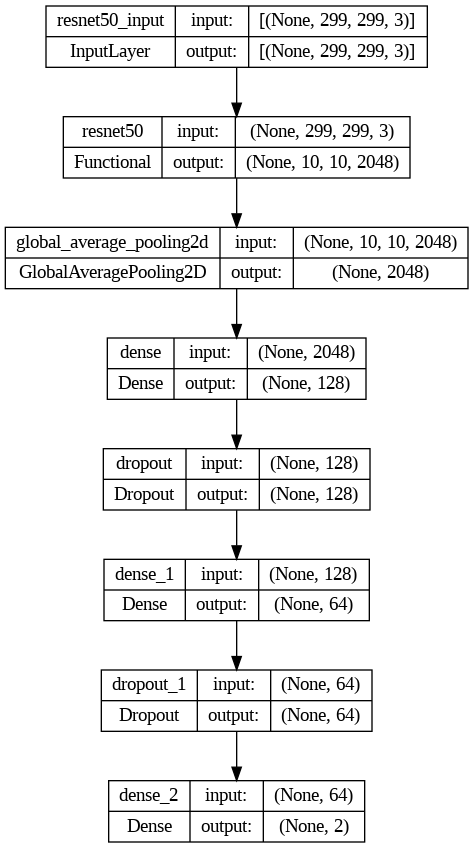

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_resnet, show_shapes=True, show_layer_names=True)

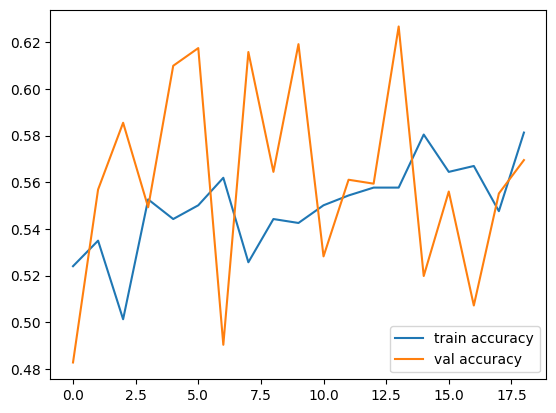

In [ ]:
plt.plot(history_resnet.history['accuracy'],label='train accuracy')
plt.plot(history_resnet.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.show()

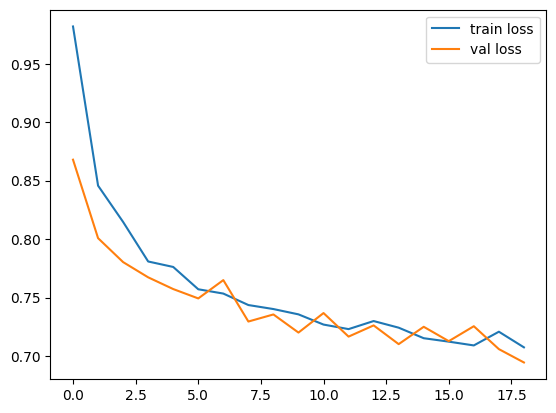

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history_resnet.history['loss'],label='train loss')
plt.plot(history_resnet.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

2/2 [==============================] - 4s 1s/step


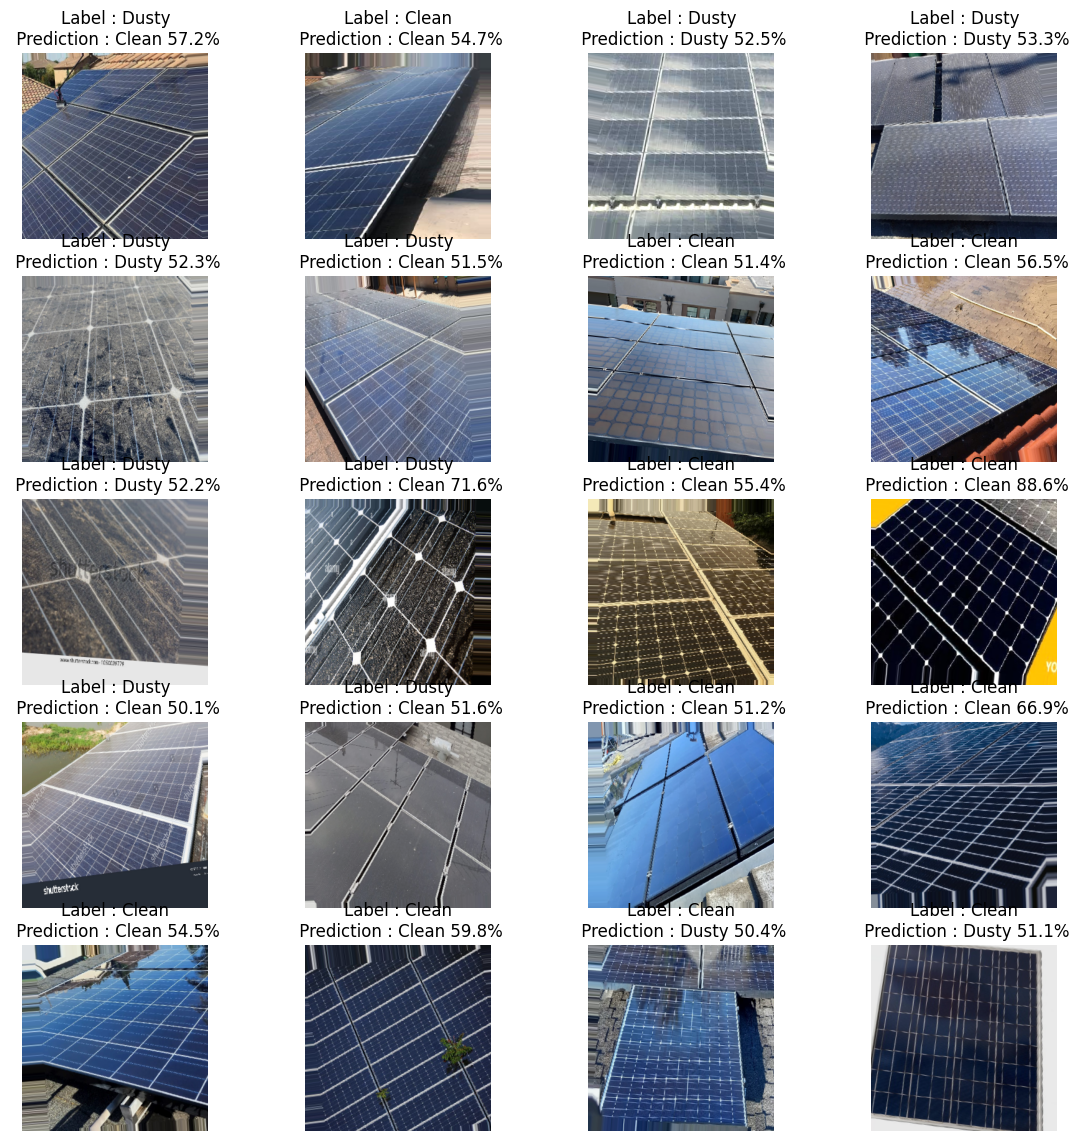

In [ ]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_resnet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [ ]:
model_resnet.save("model3.h5")
print("Saved successfully :)) ")

Saved successfully :)) 


In [ ]:
!cp model3.h5 /content/drive/MyDrive

In [ ]:
# Load the pre-trained DenseNet121 model without the top classification layer
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_densenet.layers:
    layer.trainable = False

# Create a new model and add the DenseNet121 base model
model_densenet = Sequential()
model_densenet.add(base_model_densenet)

# Add a global average pooling layer and output layer for classification
model_densenet.add(GlobalAveragePooling2D())
model_densenet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_densenet.add(Dropout(0.4))
model_densenet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_densenet.add(Dropout(0.2))
model_densenet.add(Dense(2, activation='softmax'))

# Model summary
print("Model Summary (DenseNet121):")
model_densenet.summary()
print()

# Compile the model
model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history_densenet = model_densenet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

# Validate the model
val_loss_densenet, val_accuracy_densenet = model_densenet.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_densenet:.4f}')
print(f'Validation Accuracy: {val_accuracy_densenet:.4f}')

29084464/29084464 [==============================] - 0s 0us/step
Model Summary (DenseNet121):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)        

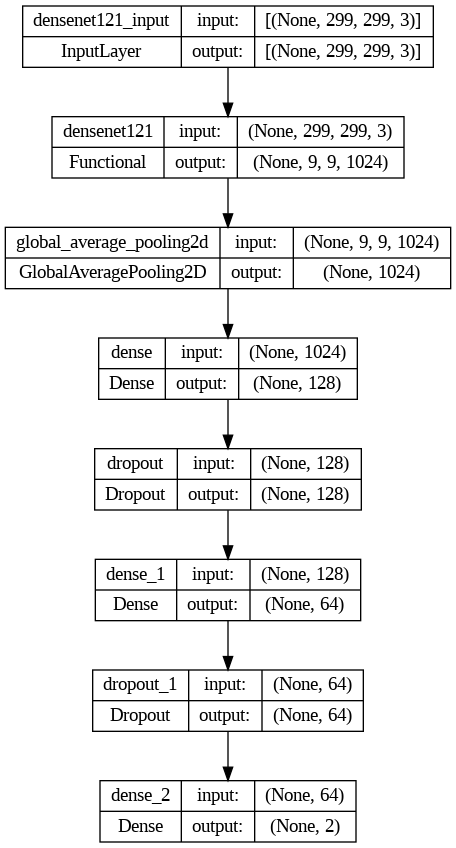

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_densenet, show_shapes=True, show_layer_names=True)

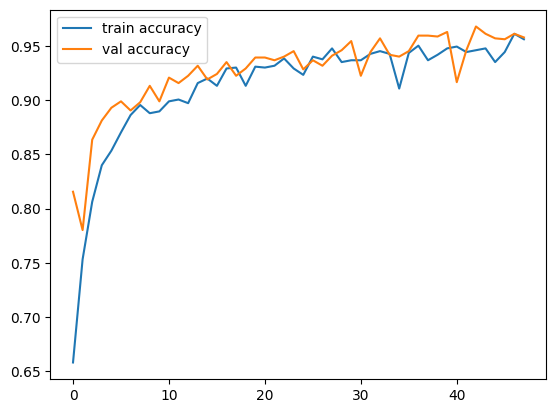

In [ ]:
plt.plot(history_densenet.history['accuracy'],label='train accuracy')
plt.plot(history_densenet.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.show()

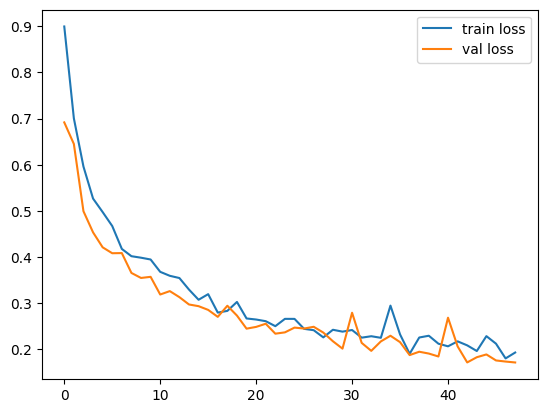

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history_densenet.history['loss'],label='train loss')
plt.plot(history_densenet.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

2/2 [==============================] - 0s 204ms/step


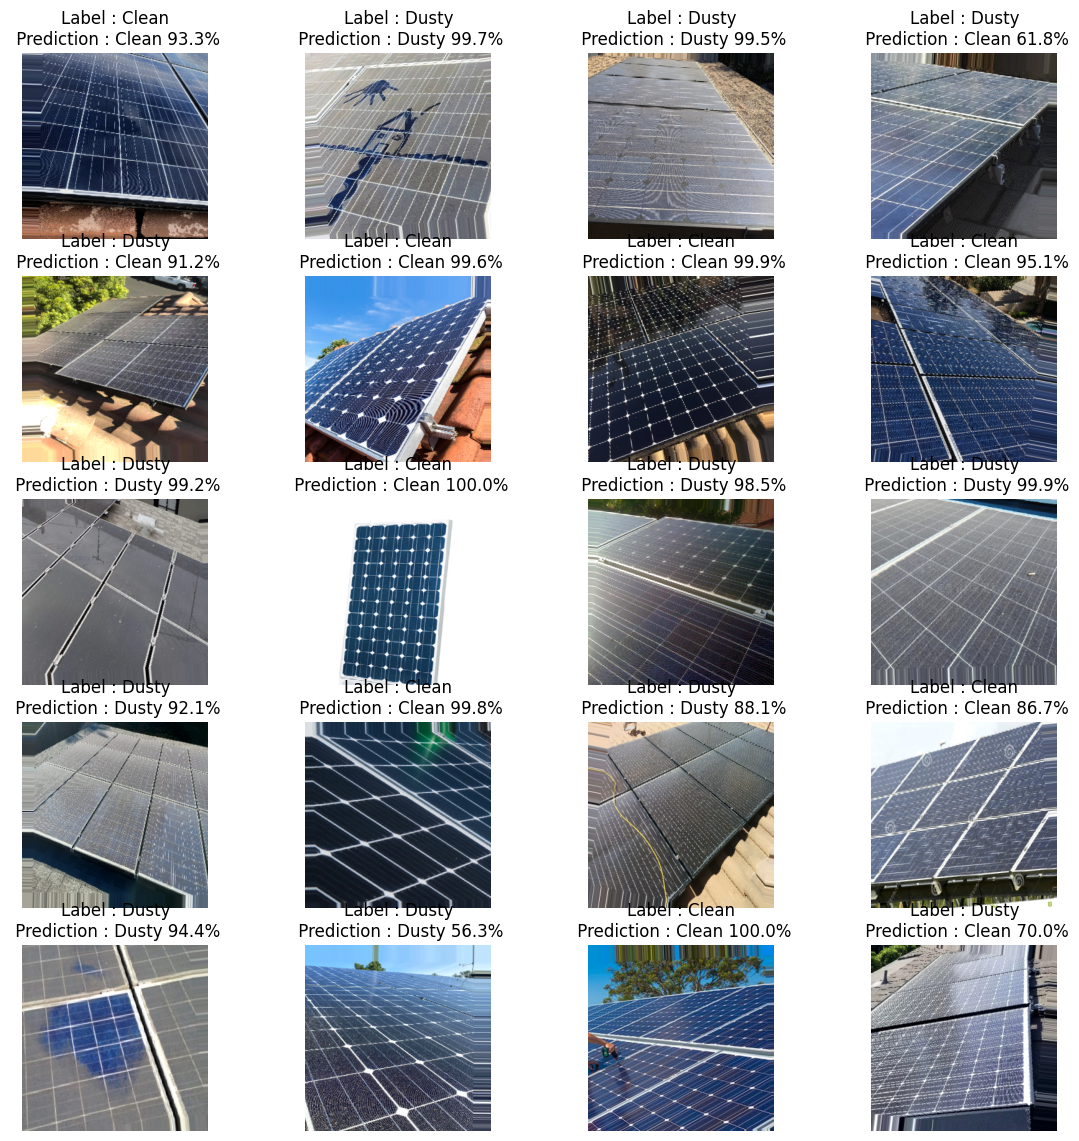

In [ ]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_densenet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [ ]:
model_densenet.save("model4.h5")
print("Saved successfully :)) ")

Saved successfully :)) 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp model4.h5 /content/drive/MyDrive

In [ ]:
# Load the pre-trained MobileNetV2 model without the top classification layer
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Create a new model and add the MobileNetV2 base model
model_mobilenet = Sequential()
model_mobilenet.add(base_model_mobilenet)

# Add a global average pooling layer and output layer for classification
model_mobilenet.add(GlobalAveragePooling2D())
model_mobilenet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_mobilenet.add(Dropout(0.4))
model_mobilenet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_mobilenet.add(Dropout(0.2))
model_mobilenet.add(Dense(2, activation='softmax'))

# Model summary
print("Model Summary (MobileNetV2):")
model_mobilenet.summary()
print()

# Compile the model
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history_mobilenet = model_mobilenet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

# Validate the model
val_loss_mobilenet, val_accuracy_mobilenet = model_mobilenet.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_mobilenet:.4f}')
print(f'Validation Accuracy: {val_accuracy_mobilenet:.4f}')

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_mobilenet, show_shapes=True, show_layer_names=True)

In [ ]:
plt.plot(history_mobilenet.history['accuracy'],label='train accuracy')
plt.plot(history_mobilenet.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_mobilenet.history['loss'],label='train loss')
plt.plot(history_mobilenet.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

In [ ]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_mobilenet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [ ]:
model_mobilenet.save("model5.h5")
print("Saved successfully :)) ")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp model5.h5 /content/drive/MyDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/model5.h5 model5